<a href="https://colab.research.google.com/github/NataliaKolesnik/Car_Price_prediction_part2/blob/master/3_%D0%9D%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D1%8C_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 10.7 MB/s 


In [ ]:
!pip install -U pymorphy2-dicts-ru

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
path_data = '/content/drive/MyDrive/SF_project_8/data/'
# path_data = '/kaggle/working/'

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

import pymorphy2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as L
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import PIL # Pillow — библиотека для работы с изображениями 
import cv2

from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


In [ ]:
pd.set_option('display.float_format', '{:.2f}'.format)

SEED = 0

FONT_TITLE = 25
FONT_LABEL = 15

## Загрузка и подготовка данных для обучения

In [ ]:
# df_train = pd.read_csv('../input/car-price-part2-230722/train_for_ML.csv')
# df_test = pd.read_csv('../input/car-price-part2-230722/test_for_ML.csv')

In [ ]:
df_train = pd.read_csv(path_data+'train_for_ML.csv')
df_test = pd.read_csv(path_data+'test_for_ML.csv')

In [ ]:
df_train.columns

Index(['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'fuelType', 'mileage', 'model_info', 'numberOfDoors',
       'price', 'productionDate', 'sell_id', 'vehicleTransmission',
       'Владельцы', 'ПТС', 'Привод', 'brand_model', 'color_littel',
       'enginePower_log', 'fuelType_littel', 'mileage_стоп_q99', 'mileage_log',
       'age_avto', 'age_avto_стоп_23', 'mileage_/_age_avto', 'xDrive',
       'Владельцы_кат', 'ПТС_10', 'price_log'],
      dtype='object')

In [ ]:
# Списки со всеми признаками

categorical_features = ['bodyType', 'brand', 'model_info', 'color', 
                             'fuelType', 'vehicleTransmission', 'ПТС', 'Привод', 'Владельцы_кат']

numerical_features = ['engineDisplacement', 'enginePower_log', 'mileage', 
                           'age_avto', 'mileage_/_age_avto', 'productionDate', 
                           'numberOfDoors', 'xDrive',]
text_features = ['brand_model', 'description']

img_features = ['sell_id']

target = ['price', 'price_log']

In [ ]:
# Стандартизируем числовые данные и категориальные в get_dummies

df_test['price'] = 0
df_test['price_log'] = 0

df_train = df_train[categorical_features + numerical_features + text_features + img_features + target]
df_test = df_test[categorical_features + numerical_features + text_features + img_features + target]

df_train['sample'] = 1
df_test['sample'] = 0

# Объединение датасетов
df_join = pd.concat([df_train, df_test])

# Стандартизация числовых признаков
scaler = MinMaxScaler()
df_join[numerical_features] = scaler.fit_transform(df_join[numerical_features])

# Кодирование категориальных
df_join = pd.get_dummies(df_join, columns=categorical_features, dummy_na=False)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
df_join.head(3)

,engineDisplacement,enginePower_log,mileage,age_avto,mileage_/_age_avto,productionDate,numberOfDoors,xDrive,brand_model,description,...,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный,Владельцы_кат_1,Владельцы_кат_2,Владельцы_кат_3
0,0.45,0.58,0.24,0.34,0.23,0.66,0.67,0.00,BMW 5ER,Авто на бодром ходу. Все работает отлично. П...,...,0,0,0,1,0,0,1,0,0,1
1,0.42,0.45,0.18,0.24,0.24,0.76,0.67,0.00,AUDI A6,"Продажа от собственника, второй владелец, ПТС ...",...,0,0,0,1,0,1,0,0,1,0
2,0.53,0.63,0.12,0.18,0.20,0.82,0.67,0.00,MERCEDES E_KLASSE,Внимание! Только для клиентов AVILON Автомобил...,...,0,0,0,1,0,0,1,0,0,1


## Разбиение датасета обратно на обучающий и тестовый

In [ ]:
X_train = df_join.query('sample == 1').drop(['sample'], axis=1)
X_test = df_join.query('sample == 0').drop(['sample', 'price', 'price_log'], axis=1)

In [ ]:
X_train.describe()

,engineDisplacement,enginePower_log,mileage,age_avto,mileage_/_age_avto,productionDate,numberOfDoors,xDrive,sell_id,price,...,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный,Владельцы_кат_1,Владельцы_кат_2,Владельцы_кат_3
count,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,...,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00,6682.00
mean,0.42,0.51,0.12,0.21,0.17,0.79,0.76,0.11,1096589310.16,1899868.12,...,0.02,0.14,0.11,0.89,0.27,0.11,0.63,0.30,0.30,0.40
std,0.16,0.17,0.08,0.13,0.09,0.13,0.29,0.32,26537466.35,1914153.12,...,0.14,0.35,0.31,0.31,0.44,0.31,0.48,0.46,0.46,0.49
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,34212938.00,301301.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.40,0.06,0.11,0.12,0.71,0.67,0.00,1097102017.00,800000.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.42,0.50,0.11,0.18,0.17,0.82,0.67,0.00,1099406919.00,1300000.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
75%,0.45,0.63,0.17,0.29,0.22,0.89,1.00,0.00,1099973288.50,2299283.25,...,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00
max,1.00,0.96,1.00,1.00,1.00,1.00,1.00,1.00,1100272894.00,23900000.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [ ]:
X_test.describe()

,engineDisplacement,enginePower_log,mileage,age_avto,mileage_/_age_avto,productionDate,numberOfDoors,xDrive,sell_id,bodyType_внедорожник,...,vehicleTransmission_механическая,vehicleTransmission_роботизированная,ПТС_Дубликат,ПТС_Оригинал,Привод_задний,Привод_передний,Привод_полный,Владельцы_кат_1,Владельцы_кат_2,Владельцы_кат_3
count,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,...,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00,1671.00
mean,0.42,0.51,0.12,0.21,0.17,0.79,0.75,0.11,1096598204.78,0.35,...,0.03,0.14,0.10,0.90,0.28,0.10,0.62,0.30,0.30,0.40
std,0.16,0.17,0.08,0.14,0.09,0.14,0.30,0.31,26734774.83,0.48,...,0.17,0.35,0.30,0.30,0.45,0.30,0.49,0.46,0.46,0.49
min,0.00,0.13,0.00,0.00,0.00,0.00,0.00,0.00,35782220.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.30,0.40,0.06,0.11,0.11,0.71,0.67,0.00,1096977148.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.41,0.50,0.11,0.18,0.16,0.82,0.67,0.00,1099404474.00,0.00,...,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00
75%,0.45,0.63,0.17,0.29,0.22,0.89,1.00,0.00,1099983811.00,1.00,...,0.00,0.00,0.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,0.76,1.00,1.00,1.00,1100272892.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


## Разбиваем датасеты

In [ ]:
# Разбиваем на обучающую и валидационную выборки

X_train, X_valid = train_test_split(X_train, test_size=0.2, random_state=SEED, shuffle=True)

In [ ]:
print('X_train:', X_train.shape)
print('X_valid:', X_valid.shape)
print('X_test: ', X_test.shape)

X_train: (5345, 181)
X_valid: (1337, 181)
X_test:  (1671, 179)


In [ ]:
# Таргеты
Y_train = X_train.price, 
Y_valid = X_valid.price

Y_train_log = X_train.price_log, 
Y_valid_log = X_valid.price_log

# Простая нейросеть
X_train_num = X_train.drop(text_features+img_features+target, axis=1)
X_valid_num = X_valid.drop(text_features+img_features+target, axis=1)
X_test_num = X_test.drop(text_features+img_features, axis=1)

X_train_img = X_train[img_features]
X_valid_img = X_valid[img_features]
X_test_img = X_test[img_features]

In [ ]:
print('X_train:', X_train_num.shape)
print('X_valid:', X_valid_num.shape)
print('X_test: ', X_test_num.shape)

X_train: (5345, 176)
X_valid: (1337, 176)
X_test:  (1671, 176)


## Работа с текстом в колонке description

In [ ]:
df_join.description.iloc[15]

'。Преднатяжители ремней безопасности\n。Крепление для детского сиденья ISOFIX\n。Подушка безопасности пассажира с функцией деактивации\n。Система динамической регулировки тяги\n。Система контроля давления в шинах\n。Безопасные шины Runflat\n。Рекуперация энергии торможения\n。Обивка салона - Кожа Dakota\n。Автоматическая коррекция угла наклона фар\n。Функция Auto Start Stop\n。Кнопка запуска/остановки двигателя\n。Сервотроник\n。Передние и задние парктроники\n。Обогрев боковых зеркал\n。Радио BMW Professional CD (CD-проигрыватель,Поддержка MP3, 8 и более динамиков,Многофункциональный цветной дисплей)\n。Разъем для подключения внешнего аудиоустройства\n。Навигационная система с жестким диском\n。Коммуникационная система Bluetooth\n\n☛ Все заявленные автомобили находятся в наличии.\n☛ Два комплекта ключей.\n☛ Выгода по программе Trade-In до 70 тысяч рублей.\n☛ Выгода в кредит до 80 тысяч рублей.\n\n\n▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼▼\n\n                       Условия при покупке автомобиля в кредит:\n\n➥ С

В данных куча мусор. С помощью регулярных выражений оставим только слова, состоящие из 3 и более букв. 

In [ ]:
df_join['text'] = df_join['description'].apply(lambda s: re.sub(r'\d+', '', s))
df_join['text'] = df_join['text'].apply(lambda s: re.split(r'\W+', s))




In [ ]:
# приведем слова разммером более 2 букв к леммам 

morph = pymorphy2.MorphAnalyzer()

def lem(x):
    x = [morph.parse(w)[0].normal_form for w in x if len(w)>1 ]
    return x

df_join['text_lem'] = df_join['text'].progress_apply(lem)

100%|██████████| 8353/8353 [03:14<00:00, 42.85it/s]


In [ ]:
# посчитаем количество уникальных слов и частоту встречаемости каждого слова

count_words = {}

for i in range(df_join.shape[0]):
    text = df_join['text_lem'].iloc[i]

    for el in text:
        if el in count_words.keys():
            count_words[el] += 1
        else:
            count_words[el] = 1

In [ ]:
# Создадим датафрейм частотности слов, чтоб удобно проанализировать какие сова можно убрать

df_words = pd.DataFrame(count_words, index = ['count']).T

In [ ]:
print(f'Всего {df_words.shape[0]} уникальный слов от 2-х букв и более')

Всего 17947 уникальный слов от 2-х букв и более


In [ ]:
# Из них тех, которые встречаюстя 1-3 раза. 

df_words[df_words['count']<=3]['count'].value_counts()

1    8292
2    2159
3    1028
Name: count, dtype: int64

In [ ]:
# Особо часто встречающиеся
df_words[df_words['count']>4000]['count'].sort_values()

до             4046
от             4198
машина         4561
передний       4764
для            4927
состояние      5270
год            5322
сидение        5872
салон          5959
задний         6250
всё            6349
пробег         6403
система        9045
по            10043
не            10673
на            15600
автомобиль    17352
Name: count, dtype: int64

In [ ]:
# Список слов для обучения с частотой встречаемостии более 3-х раз и менее 4000
word_for_train = list(df_words[(df_words['count']>3) & (df_words['count']<4000)].index)

In [ ]:
df_join['brand_model']

0                 BMW 5ER
1                 AUDI A6
2       MERCEDES E_KLASSE
3                 AUDI A6
4                 AUDI A5
              ...        
1666              BMW 3ER
1667               BMW X5
1668              AUDI Q3
1669              BMW 5ER
1670              AUDI A4
Name: brand_model, Length: 8353, dtype: object

In [ ]:
# Удалим редко и часто встречающиеся слова из описания

def word_train(x):
    new_list_word = []
    for el in x:
        if el in word_for_train:
            new_list_word.append(el)
    return new_list_word

df_join['text_lem_train'] = df_join['text_lem'].progress_apply(word_train)
df_join['text_lem_train'] = df_join['brand_model'].apply(lambda s: s.split(' '))+df_join['text_lem_train']

100%|██████████| 8353/8353 [00:34<00:00, 240.68it/s]


In [ ]:
df_join['text_lem_train']

0       [BMW, 5ER, авто, бодрый, ход, работать, отличн...
1       [AUDI, A6, продажа, собственник, второй, владе...
2       [MERCEDES, E_KLASSE, внимание, только, клиент,...
3       [AUDI, A6, комплект, зимний, колесо, замена, т...
4       [AUDI, A5, отличный, авто, выпуск, кроме, левы...
                              ...                        
1666    [BMW, 3ER, продаваться, любимица, семья, польз...
1667    [BMW, X5, продажа, компания, ао, abtodom, офиц...
1668    [AUDI, Q3, идеальный, технический, обслуживани...
1669    [BMW, 5ER, приобретаться, новый, дилер, avilon...
1670    [AUDI, A4, id, комплектация, comfort, выпуск, ...
Name: text_lem_train, Length: 8353, dtype: object

In [ ]:
word_for_train_with_brend_model = set()

for i in range(df_join.shape[0]):
    text = df_join['text_lem_train'].iloc[i]

    for el in text:
        word_for_train_with_brend_model.add(el)

In [ ]:
len(word_for_train_with_brend_model)

6576

In [ ]:
# Создадим и обучим токенайзер
num_words = len(word_for_train_with_brend_model)

tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df_join['text_lem_train'])

In [ ]:
items = list(tokenizer.word_index.items())
print(items[260:280])

[('реальный', 261), ('аварийный', 262), ('никакой', 263), ('перед', 264), ('обслужить', 265), ('просьба', 266), ('я', 267), ('акпп', 268), ('момент', 269), ('дальний', 270), ('находиться', 271), ('avilon', 272), ('антиблокировочный', 273), ('своевременный', 274), ('автокредит', 275), ('тот', 276), ('bluetooth', 277), ('участвовать', 278), ('ауди', 279), ('передача', 280)]


### Делим подготовленный текст на выборки и формируем датасеты для подачи в model_nlp

In [ ]:
X_train_text = df_join.query('sample == 1')[['text_lem_train']].iloc[X_train.index]
X_valid_text = df_join.query('sample == 1')[['text_lem_train']].iloc[X_valid.index]
X_test_text = df_join.query('sample == 0')[['text_lem_train']]

In [ ]:
print('X_train_text:', X_train_text.shape)
print('X_valid_text:', X_valid_text.shape)
print('X_test_text: ', X_test_text.shape)

X_train_text: (5345, 1)
X_valid_text: (1337, 1)
X_test_text:  (1671, 1)


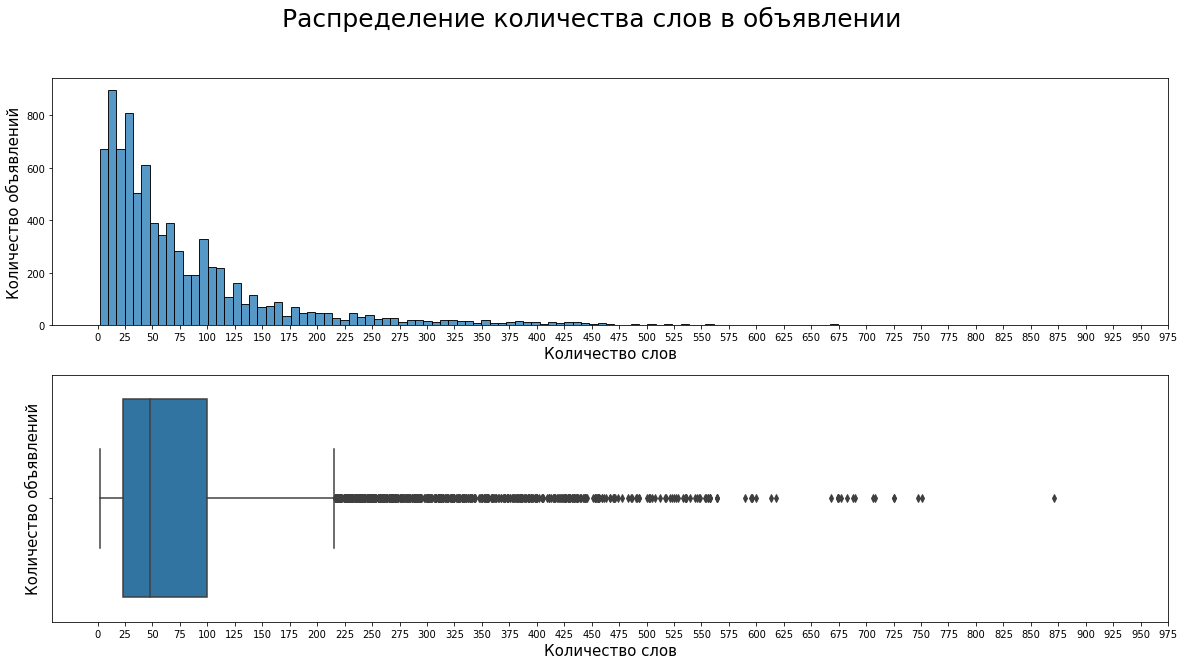

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(20,10))
plt.suptitle('Распределение количества слов в объявлении', fontsize=FONT_TITLE)

sns.histplot(data=df_join['text_lem_train'].apply(len), ax=ax[0])
ax[0].set_xlabel('Количество слов', fontsize=FONT_LABEL)
ax[0].set_ylabel('Количество объявлений', fontsize=FONT_LABEL)
ax[0].set_xticks([x for x in range(0, 1000, 25)])

sns.boxplot(x=df_join['text_lem_train'].apply(len), ax=ax[1])
ax[1].set_xlabel('Количество слов', fontsize=FONT_LABEL)
ax[1].set_ylabel('Количество объявлений', fontsize=FONT_LABEL)
ax[1].set_xticks([x for x in range(0, 1000, 25)])
plt.show()

Длину текста объявления оптимально будет выбирать от 150 до 200 слов.

In [ ]:
MAX_SEQUENCE_LENGTH = 150

train_sequences = tokenizer.texts_to_sequences(X_train_text['text_lem_train'])

X_train_text_num = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

vaid_sequences = tokenizer.texts_to_sequences(X_valid_text['text_lem_train'])

X_valid_text_num = pad_sequences(vaid_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

test_sequences = tokenizer.texts_to_sequences(X_test_text['text_lem_train'])

X_test_text_num = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

In [ ]:
print(X_train_text['text_lem_train'].iloc[150])

['AUDI', 'A8', 'можно', 'приобрести', 'безналичный', 'расчёт', 'полный', 'возврат', 'ндс', 'приобретаться', 'официальный', 'дилер', 'декабрь', 'оригинальный', 'птс', 'владелец', 'кузов', 'полностью', 'оригинальный', 'заводский', 'краска', 'дополнительный', 'опция', 'камера', 'вид', 'светодиодный', 'освещение', 'автодоводчик', 'дверь', 'люк', 'электропривод', 'зонный', 'климат', 'контроль', 'электропривод', 'память', 'вентиляция', 'электропривод', 'память', 'бесключевой', 'доступ', 'запуск', 'двигатель', 'электропривод', 'обогрев', 'руль', 'круиз', 'контроль']


In [ ]:
X_train_text_num[150]

array([  19,  985,  233,  350,  679,  655,   37, 5399, 1594,  859,    8,
          6,  750,   72,   25,   48,   53,  109,   72,  306,  338,   80,
        500,  108,  111,  169,  315,  759,   66,  234,   71,  209,   75,
         26,   71,  104,  240,   71,  104,  720,  202,  302,   44,   71,
         56,   17,  151,   26,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0], d

## Работа с изображениями

In [ ]:
path_img = path_data+'img/img/'

# sell_id - содержит номер файла изображения
X_train_img = df_train['sell_id'].iloc[X_train.index]
X_valid_img = df_train['sell_id'].iloc[X_valid.index]
X_test_img = df_test['sell_id']

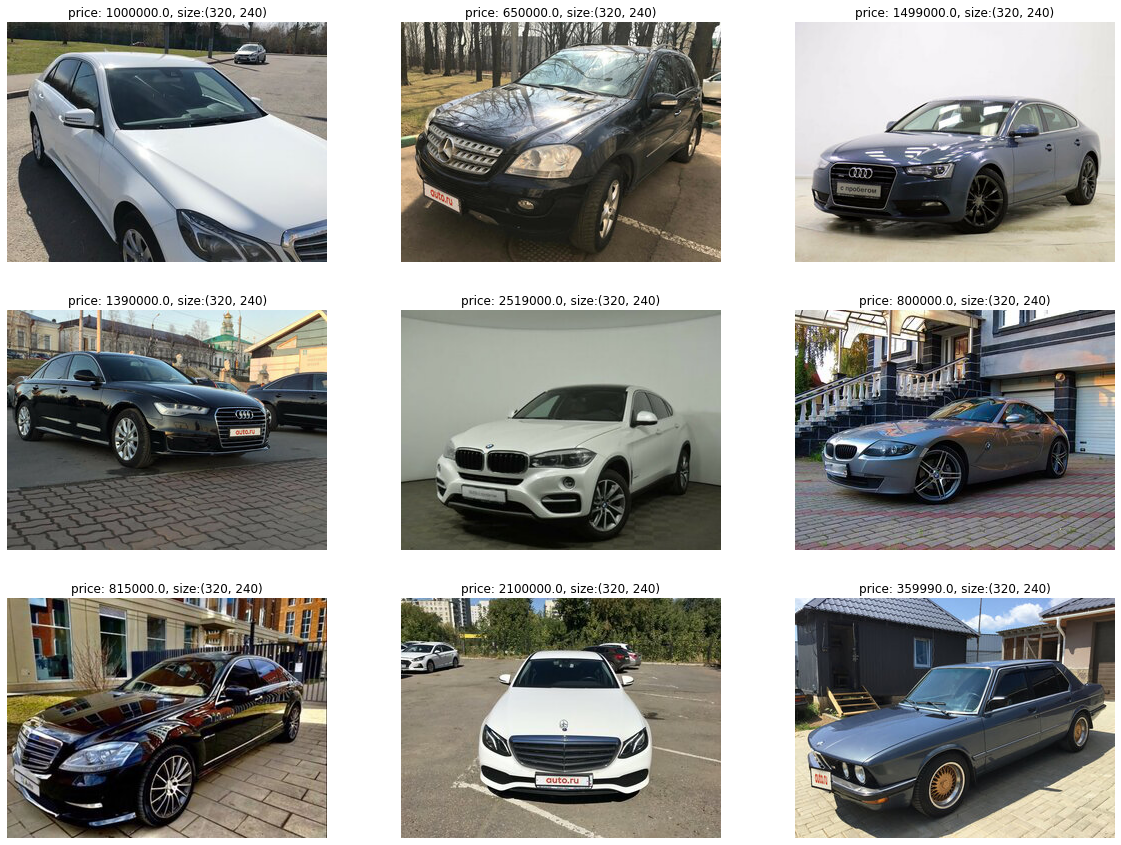

In [ ]:
plt.figure(figsize = (20,15))

random_image = df_train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(path_img + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]) + ', size:' + str(im.size))
    plt.axis('off')
plt.show()

In [ ]:
size = (320, 240)

def get_image_array(df):
    
    images_train = []
    for sell_id in tqdm(df.values):
        image = cv2.imread(path_img + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
        
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train_img)
images_valid = get_image_array(X_valid_img)
images_test = get_image_array(X_test_img)

100%|██████████| 5345/5345 [19:07<00:00,  4.66it/s]


images shape (5345, 240, 320, 3) dtype uint8


100%|██████████| 1337/1337 [04:39<00:00,  4.79it/s]


images shape (1337, 240, 320, 3) dtype uint8


100%|██████████| 1671/1671 [05:52<00:00,  4.74it/s]


images shape (1671, 240, 320, 3) dtype uint8


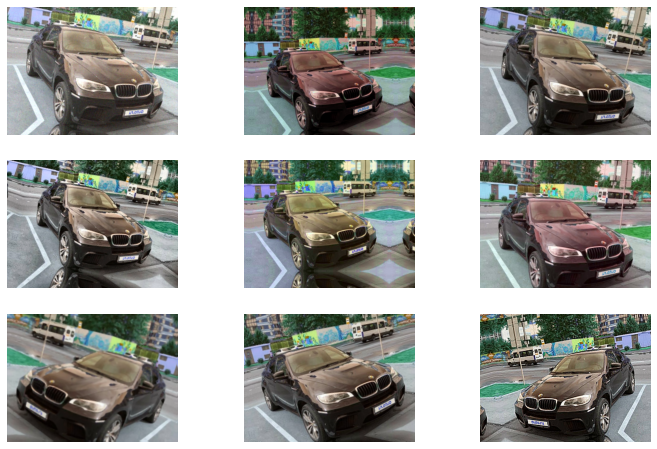

In [ ]:
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [ ]:
# def make_augmentations(images):
#   print('применение аугментаций', end = '')
#   augmented_images = np.empty(images.shape)
#   for i in range(images.shape[0]):
#     if i % 200 == 0:
#       print('.', end = '')
#     augment_dict = augmentation(image = images[i])
#     augmented_image = augment_dict['image']
#     augmented_images[i] = augmented_image
#   print('')
#   return augmented_images

In [ ]:
# x = make_augmentations(images_train)

In [ ]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
    return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    # [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    # [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train_num, X_train_text_num, Y_train
    )).map(tf_process_train_dataset_element)

valid_dataset = tf.data.Dataset.from_tensor_slices((
    images_valid, X_valid_num, X_valid_text_num, Y_valid
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_test))
test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test_num, X_test_text_num, y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
valid_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();

## Обучение модели

In [ ]:
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB6(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_model.trainable = True
# Заморозим часть слоев
for layer in efficientnet_model.layers[:len(efficientnet_model.layers)//2]:
    layer.trainable = False
    
efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)

165249024/165234480 [==============================] - 2s 0us/step


In [ ]:
tabular_model = Sequential([
    L.Input(shape = X_train_num.shape[1]),
    L.Dense(512, activation = 'sigmoid'),
    L.LayerNormalization(),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dense(128, activation = 'relu'),
    L.Dropout(0.25)    
    ])

In [ ]:
nlp_model = Sequential([
    #L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(num_words, 50, input_length=MAX_SEQUENCE_LENGTH),
    L.LayerNormalization(),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.Dense(128, activation = 'sigmoid'),
    L.LSTM(64),
    L.Dropout(0.25),
    L.Dense(64),
    ])


In [ ]:
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 240, 320, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 241, 321, 3)  0           ['normalization[0][0]']      

In [ ]:
# model_nlp = Sequential([
#     Embedding(num_words, 32, input_length=MAX_SEQUENCE_LENGTH),
#     LSTM(256, return_sequences=True),
#     Dropout(0.5),
#     LSTM(128,),
#     Dropout(0.25),
#     Dense(64, activation="relu"),
#     Dropout(0.25)])

In [ ]:
# # создаем модель
# model_mlp = Sequential([Dense(512, input_dim=X_train.shape[1], activation="relu"),
#                     Dropout(0.5),
#                     BatchNormalization(), 
#                     Dense(256, activation="relu"),
#                     Dropout(0.5),
#                     Dense(1, activation="linear")])


In [ ]:
# combinedInput = concatenate([model_nlp.output, model_mlp.output])
# # being our regression head
# head = Dense(64, activation="relu")(combinedInput)
# head = Dense(1, activation="linear")(head)

# model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)


In [ ]:
# model.summary()

In [ ]:
optimizer = Adam(0.005)

# Определим нашу функцию-метрику
def MAPE(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [ ]:
checkpoint = ModelCheckpoint(path_data+'best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [ ]:
history = model.fit(train_dataset.batch(30),
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=valid_dataset.batch(30),
                    callbacks=callbacks_list
                   )


Epoch 1/500
179/179 [==============================] - 6646s 37s/step - loss: 48.3554 - MAPE: 48.3554 - val_loss: 33.6744 - val_MAPE: 33.6744
Epoch 2/500
179/179 [==============================] - 6642s 37s/step - loss: 27.6419 - MAPE: 27.6419 - val_loss: 21.4882 - val_MAPE: 21.4882
Epoch 3/500
179/179 [==============================] - 6717s 38s/step - loss: 21.5751 - MAPE: 21.5751 - val_loss: 18.9322 - val_MAPE: 18.9322
Epoch 4/500
179/179 [==============================] - 6634s 37s/step - loss: 19.3275 - MAPE: 19.3275 - val_loss: 16.6605 - val_MAPE: 16.6605
Epoch 5/500
179/179 [==============================] - 6623s 37s/step - loss: 18.2684 - MAPE: 18.2684 - val_loss: 17.4274 - val_MAPE: 17.4274
Epoch 6/500
134/179 [=====================>........] - ETA: 25:11 - loss: 17.8904 - MAPE: 17.8904

In [ ]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='valid')
plt.legend()
plt.show();


In [ ]:
model.load_weights(path_data +'best_model.hdf5')
#model.save('../working/nn_1.hdf5')

In [ ]:
y_valid_predict = model.predict(valid_dataset.batch(30))
print(f"TEST mape: {(MAPE(Y_valid, y_valid_predict[:,0]))*100:0.2f}%")
# print(f"TEST mape: {(MAPE(np.exp(Y_valid), np.exp(y_valid_predict[:,0])))*100:0.2f}%")

## Предсказание

In [1]:
# предсказываем результат 
y_test_predict = model.predict(test_dataset.batch(30))

NameError: ignored

In [ ]:
y_test_predict

In [ ]:
# y_test_predict = np.exp(y_test_predict[:,0])

In [ ]:
submission = pd.read_csv(path_data+'sample_submission.csv')
submission['price'] = y_test_predict
submission.to_csv(path_data + 'sample_submission_nn_with_text_img.csv', index=False)

In [ ]:
submission